In [1]:
import os
import pandas as pd
import numpy as np

def process_folder(folder_path, compliance_limits):
    data_df = []  # Data for output CSV
    data_folder = []  # Accumulate data for results

    for filename in os.listdir(folder_path):
        # Skip non-Pickle files
        if not filename.endswith(".pkl"):
            continue

        file_path = os.path.join(folder_path, filename)
        data_file = []
        
        try:
            data_file = pd.read_pickle(file_path)
        except pd.errors.EmptyDataError:
            print(f"Warning: Empty DataFrame in file {file_path}")
            continue

        if data_file.empty or any(col not in data_file.columns for col in ['bod1', 'cod1', 'bod31', 'cod31', 'snh1', 'snh31']):
            print(f"Warning: Missing columns in file {file_path}")
            continue
        
        # BOD limit calculations
        data_file['BODut'] = abs((compliance_limits["bod_upper"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))
        data_file['BODlt'] = abs((compliance_limits["bod_lower"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))

        # COD limit calculations
        data_file['CODut'] = abs((compliance_limits["cod_upper"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))
        data_file['CODlt'] = abs((compliance_limits["cod_lower"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))

        # Lineration of BOD influent and effluent
        data_file["LIN_BODe"] = abs((data_file["bod31"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))
        data_file["LIN_BODi"] = abs((data_file["bod1"] - data_file["bod31"].min()) / (data_file["bod1"].max() - data_file["bod31"].min()))

        # Lineration of COD influent and effluent
        data_file["LIN_CODe"] = abs((data_file["cod31"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))
        data_file["LIN_CODi"] = abs((data_file["cod1"] - data_file["cod31"].min()) / (data_file["cod1"].max() - data_file["cod31"].min()))

        data_file['BODut-BODeffl'] = (data_file["BODut"] - data_file["LIN_BODe"])
        data_file['CODut-CODeffl'] = (data_file["CODut"] - data_file["LIN_CODe"])
        data_file['BODlt-BODeffl'] = (data_file["BODlt"] - data_file["LIN_BODe"])
        data_file['CODlt-CODeffl'] = (data_file["CODlt"] - data_file["LIN_CODe"])
       
        data_file["bodp"] = -(compliance_limits["bod_pc"] * data_file["LIN_BODi"]) + data_file["LIN_BODi"] - data_file["LIN_BODe"]
        data_file["codp"] = -(compliance_limits["cod_pc"] * data_file["LIN_CODi"]) + data_file["LIN_CODi"] - data_file["LIN_CODe"]

        data_file["max1"] = data_file[['BODlt-BODeffl', 'bodp']].max(axis=1)
        data_file['c_BOD'] = data_file[['BODut-BODeffl', 'max1']].min(axis=1)
        data_file["max2"] = data_file[['CODlt-CODeffl', 'codp']].max(axis=1)
        data_file['c_COD'] = data_file[['CODut-CODeffl', 'max2']].min(axis=1)

        # Flags
        data_file["flag_BODlt"] = data_file['BODlt-BODeffl'] >= 0
        data_file["flag_CODlt"] = data_file['CODlt-CODeffl'] >= 0
        data_file["flag_reduction_bod"] = data_file["bodp"] >= 0
        data_file["flag_reduction_cod"] = data_file["codp"] >= 0
        data_file["flag_BODut"] = data_file['BODut-BODeffl'] >= 0
        data_file["flag_CODut"] = data_file['CODut-CODeffl'] >= 0
        data_file["metric"] = data_file[["c_COD", "c_BOD"]].min(axis=1)

        # BOD FAILURE conditions
        bod_lut_exc = (data_file['c_BOD'] < 0) & (data_file["flag_BODlt"] == False) & (data_file["flag_reduction_bod"] == False) & (data_file["flag_BODut"] == True)
        bod_max_lim = (data_file['c_BOD'] < 0) & (data_file["flag_BODlt"] == False) & (data_file["flag_BODut"] == False)

        # COD FAILURE conditions
        cod_lut_exc = (data_file['c_COD'] < 0) & (data_file["flag_CODlt"] == False) & (data_file["flag_reduction_cod"] == False) & (data_file["flag_CODut"] == True)
        cod_max_lim = (data_file['c_COD'] < 0) & (data_file["flag_CODlt"] == False) & (data_file["flag_CODut"] == False)

        # Apply the conditions and set fail_type
        fail_type_conditions = [
            bod_lut_exc, bod_max_lim,  # BOD conditions
            cod_lut_exc, cod_max_lim   # COD conditions
        ]

        fail_type_values = [
            "LUT exceedance", "Max Limit Failure",  # BOD fail types
            "LUT exceedance", "Max Limit Failure"   # COD fail types
        ]

        # Assign the fail_type using np.select()
        data_file["fail_type"] = np.select(fail_type_conditions, fail_type_values, default="Compliant")

        # Set the fail_source based on which condition was met
        data_file["fail_source"] = np.select(
            [bod_lut_exc | bod_max_lim, cod_lut_exc | cod_max_lim], 
            ["BOD", "COD"], 
            default="None"
        )

        # Optionally, for "LUT exceedance" or "Max Limit Failure" conditions, set additional flags
        data_file["bod_lut_exc"] = bod_lut_exc
        data_file["bod_max_lim"] = bod_max_lim
        data_file["cod_lut_exc"] = cod_lut_exc
        data_file["cod_max_lim"] = cod_max_lim

        df = pd.DataFrame(data_df)
        csv_name = os.path.basename(folder_path)
        df.to_csv(f'{csv_name}.csv', index=False) 
        
        # Concat data file to data_folder
        data_folder.append(data_file)
        
    # Return the concatenated results from all the files in the folder
    if not data_folder == []:
        # Create a DataFrame from the accumulated data
        result_df =  pd.concat(data_folder, ignore_index=True)
        result_df.to_csv(f"{csv_name}_full.csv", index=False)
        return result_df
    else:
        print(f"Warning: No data to return for folder {folder_path}")
        return pd.DataFrame()  # Return an empty DataFrame if no data

# CONSTANTS
BOD_UPPER = 50
BOD_LOWER = 25
COD_UPPER = 250
COD_LOWER = 125
BOD_PC = 0.7
COD_PC = 0.75

# Define folder paths
root_path = os.getcwd() + '\\'

# sub folders
folder_path_1 = root_path + 'baseline'
folder_path_2 = root_path + '1.3'
folder_path_3 = root_path + '1.5'
folder_path_4 = root_path + '1.9'

compliance_limits = {
    "bod_upper": BOD_UPPER,
    "bod_lower": BOD_LOWER,
    "cod_upper": COD_UPPER,
    "cod_lower": COD_LOWER,
    "bod_pc" : BOD_PC,
    "cod_pc" : COD_PC
}

# Process each folder
result_baseline = process_folder(folder_path_1, compliance_limits)
results_1_3 = process_folder(folder_path_2, compliance_limits)
results_1_5 = process_folder(folder_path_3, compliance_limits)
results_1_9 = process_folder(folder_path_4, compliance_limits)


datasets = [
    (result_baseline, "Baseline"),
    (results_1_3, "Shift 130%"),
    (results_1_5, "Shift 150%"),
    (results_1_9, "Shift 190%")
]

title = ["Baseline", "Shift 130%", "Shift 150%", "Shift 190%"]

# Define the x and y columns for each case
xy_columns = [
    ("LIN_BODi", "c_BOD"),
    ("LIN_BODe", "c_BOD"),
    ("LIN_CODi", "c_COD"),
    ("LIN_CODe", "c_COD")
]

import pandas as pd

# Count where fail_type is "Compliant", "LUT exceedance", "Max Limit Failure" and fail_source counts
baseline_compliant_count = (result_baseline["fail_type"] == "Compliant").sum()
baseline_lut_count = (result_baseline["fail_type"] == "LUT exceedance").sum()
baseline_max_lim = (result_baseline["fail_type"] == "Max Limit Failure").sum()
baseline_bod_source = (result_baseline["fail_source"] == "BOD").sum()
baseline_cod_source = (result_baseline["fail_source"] == "COD").sum()
baseline_pass_source = (result_baseline["fail_source"] == "None").sum()

_1_3_compliant_count = (results_1_3["fail_type"] == "Compliant").sum()
_1_3_lut_count = (results_1_3["fail_type"] == "LUT exceedance").sum()
_1_3_max_lim = (results_1_3["fail_type"] == "Max Limit Failure").sum()
_1_3_bod_source = (results_1_3["fail_source"] == "BOD").sum()
_1_3_cod_source = (results_1_3["fail_source"] == "COD").sum()
_1_3_pass_source = (results_1_3["fail_source"] == "None").sum()

_1_5_compliant_count = (results_1_5["fail_type"] == "Compliant").sum()
_1_5_lut_count = (results_1_5["fail_type"] == "LUT exceedance").sum()
_1_5_max_lim = (results_1_5["fail_type"] == "Max Limit Failure").sum()
_1_5_bod_source = (results_1_5["fail_source"] == "BOD").sum()
_1_5_cod_source = (results_1_5["fail_source"] == "COD").sum()
_1_5_pass_source = (results_1_5["fail_source"] == "None").sum()

_1_9_compliant_count = (results_1_9["fail_type"] == "Compliant").sum()
_1_9_lut_count = (results_1_9["fail_type"] == "LUT exceedance").sum()
_1_9_max_lim = (results_1_9["fail_type"] == "Max Limit Failure").sum()
_1_9_bod_source = (results_1_9["fail_source"] == "BOD").sum()
_1_9_cod_source = (results_1_9["fail_source"] == "COD").sum()
_1_9_pass_source = (results_1_9["fail_source"] == "None").sum()

# Create a DataFrame to display the results in a table format
data = {
    "Category": ["Baseline", "130%", "150%", "190%"],
    "Compliant Count": [baseline_compliant_count, _1_3_compliant_count, _1_5_compliant_count, _1_9_compliant_count],
    "LUT Exceedance Count": [baseline_lut_count, _1_3_lut_count, _1_5_lut_count, _1_9_lut_count],
    "Max Limit Failure Count": [baseline_max_lim, _1_3_max_lim, _1_5_max_lim, _1_9_max_lim],
    "BOD Source Count": [baseline_bod_source, _1_3_bod_source, _1_5_bod_source, _1_9_bod_source],
    "COD Source Count": [baseline_cod_source, _1_3_cod_source, _1_5_cod_source, _1_9_cod_source],
    "Pass Source Count": [baseline_pass_source, _1_3_pass_source, _1_5_pass_source, _1_9_pass_source]
}

# Convert the dictionary into a pandas DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame as a table
display(results_df)


,Category,Compliant Count,LUT Exceedance Count,Max Limit Failure Count,BOD Source Count,COD Source Count,Pass Source Count
0,Baseline,4782,406,69,475,0,4782
1,130%,44,0,5213,5213,0,44
2,150%,33,0,5224,5224,0,33
3,190%,29,0,5228,5228,0,29


In [10]:
# Simple numeric non-stationarity measure
def non_stationarity_score(series, window=30):
    """
    Returns a numeric score indicating non-stationarity.
    Higher score → more non-stationary.
    """
    rolling_var = series.rolling(window=window).var()
    overall_var = series.var()
    
    # Measure: mean absolute deviation of rolling variance normalized by overall variance
    score = (rolling_var - overall_var).abs().mean() / overall_var
    return score

# Prepare a table of non-stationarity scores
series_to_check = ["LIN_BODi", "LIN_BODe", "LIN_CODi", "LIN_CODe"]

results_ns = []

for df, label in datasets:
    if df.empty:
        continue
    row = {"Dataset": label}
    for col in series_to_check:
        row[col] = non_stationarity_score(df[col])
    results_ns.append(row)

ns_df = pd.DataFrame(results_ns)
display(ns_df)




,Dataset,LIN_BODi,LIN_BODe,LIN_CODi,LIN_CODe
0,Baseline,0.370871,0.654149,0.370102,0.654094
1,Shift 130%,0.394497,0.544982,0.394221,0.544710
2,Shift 150%,0.394402,0.503561,0.394139,0.503509
3,Shift 190%,0.420061,0.528666,0.419745,0.528444


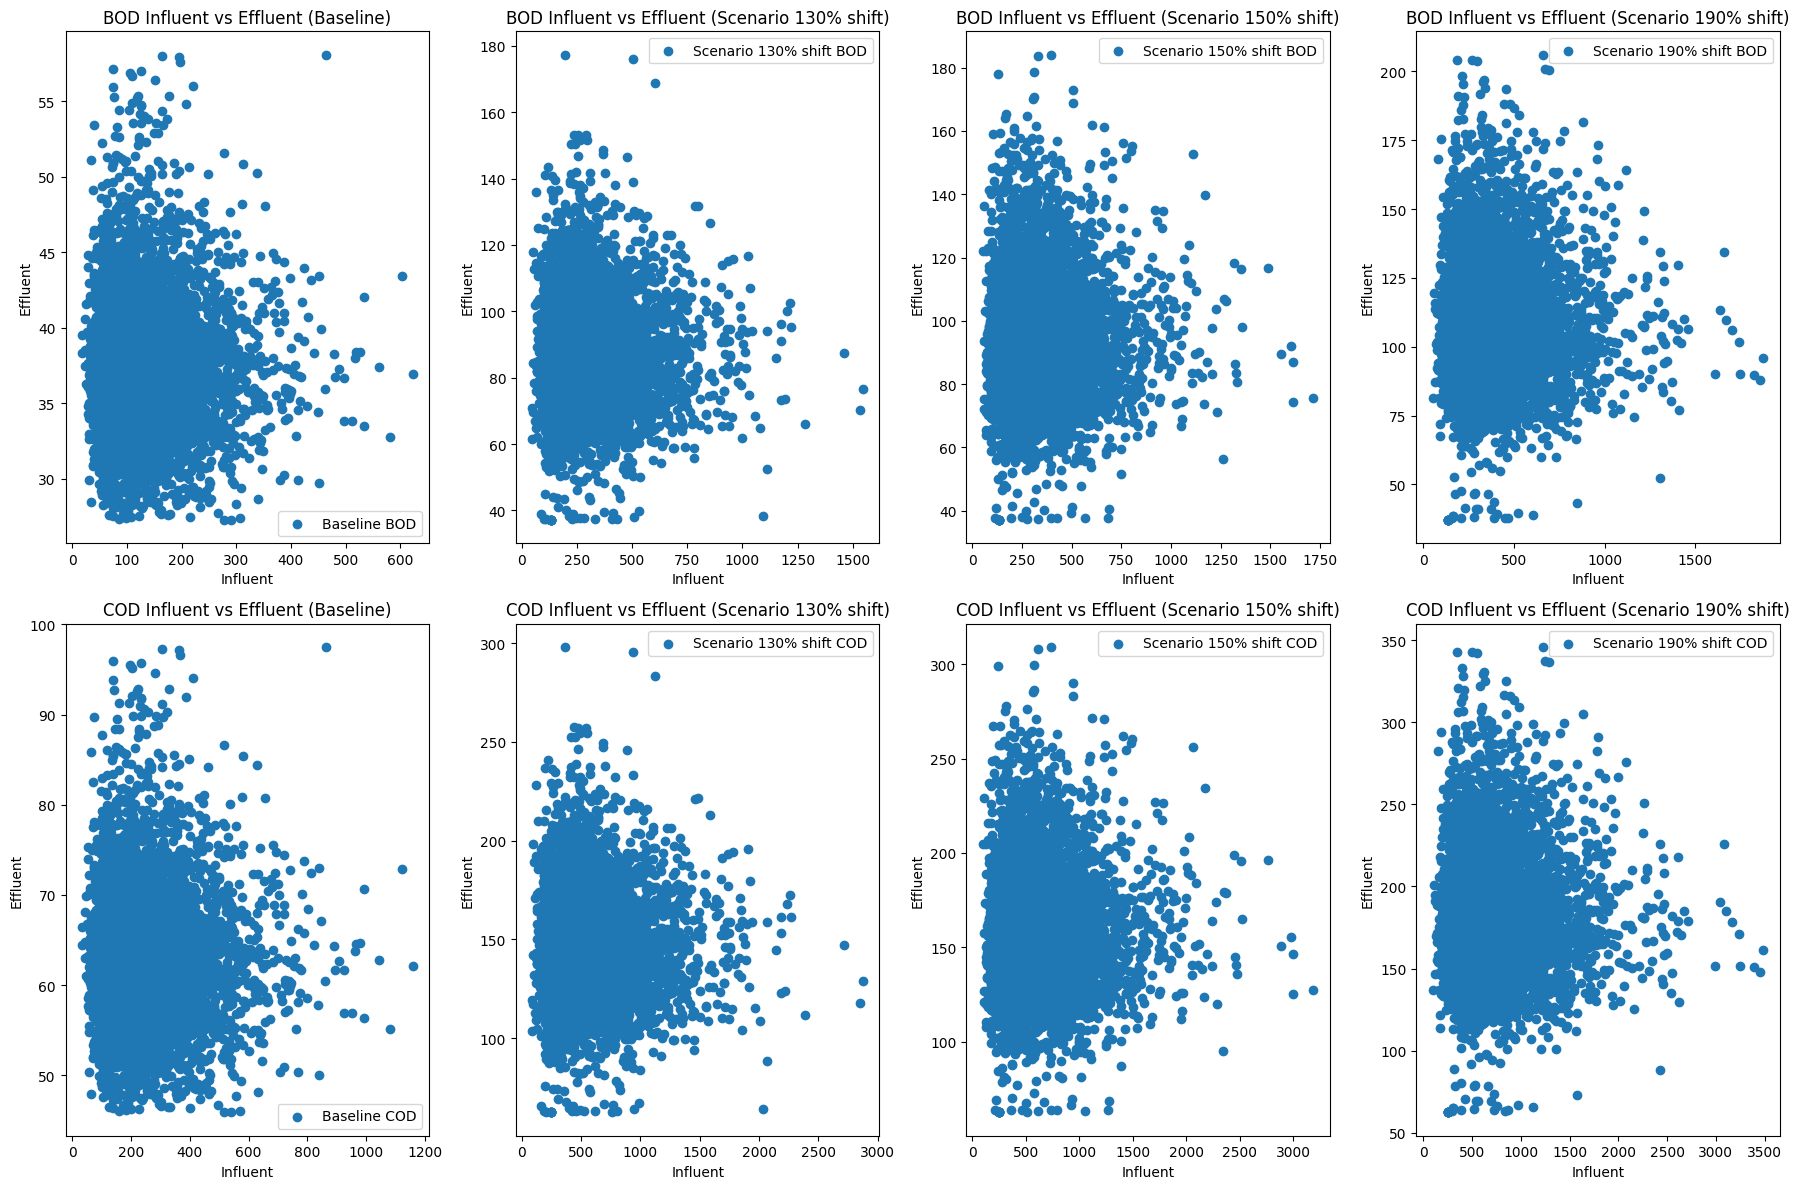

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure for each plot
fig, axs = plt.subplots(2, 4, figsize=(18, 12))  # 3 rows, 4 columns

# Define the titles and data for each scenario and parameter
parameters = ['BOD', 'COD']
scenarios = ['Baseline', 'Scenario 130% shift', 'Scenario 150% shift', 'Scenario 190% shift']

param_to_influent = {
    'BOD': [result_baseline["bod1"], results_1_3["bod1"], results_1_5["bod1"], results_1_9["bod1"]],
    'COD': [result_baseline["cod1"], results_1_3["cod1"], results_1_5["cod1"], results_1_9["cod1"]],
}

param_to_effluent = {
    'BOD': [result_baseline["bod31"], results_1_3["bod31"], results_1_5["bod31"], results_1_9["bod31"]],
    'COD': [result_baseline["cod31"], results_1_3["cod31"], results_1_5["cod31"], results_1_9["cod31"]],
}

# Loop through parameters and scenarios to generate the plots
for i, param in enumerate(parameters):
    for j, scenario in enumerate(scenarios):
        # Sort the influent and effluent data
        influent_sorted = np.sort(param_to_influent[param][j])
        # Sort the corresponding effluent data based on the sorted influent data
        effluent_sorted = np.array(param_to_effluent[param][j])[np.argsort(param_to_influent[param][j])]
        
        # Plot the sorted data
        axs[i, j].scatter(influent_sorted, effluent_sorted, label=f'{scenario} {param}')
        axs[i, j].set_xlabel('Influent')
        axs[i, j].set_ylabel('Effluent')
        axs[i, j].set_title(f'{param} Influent vs Effluent ({scenario})')
        axs[i, j].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()





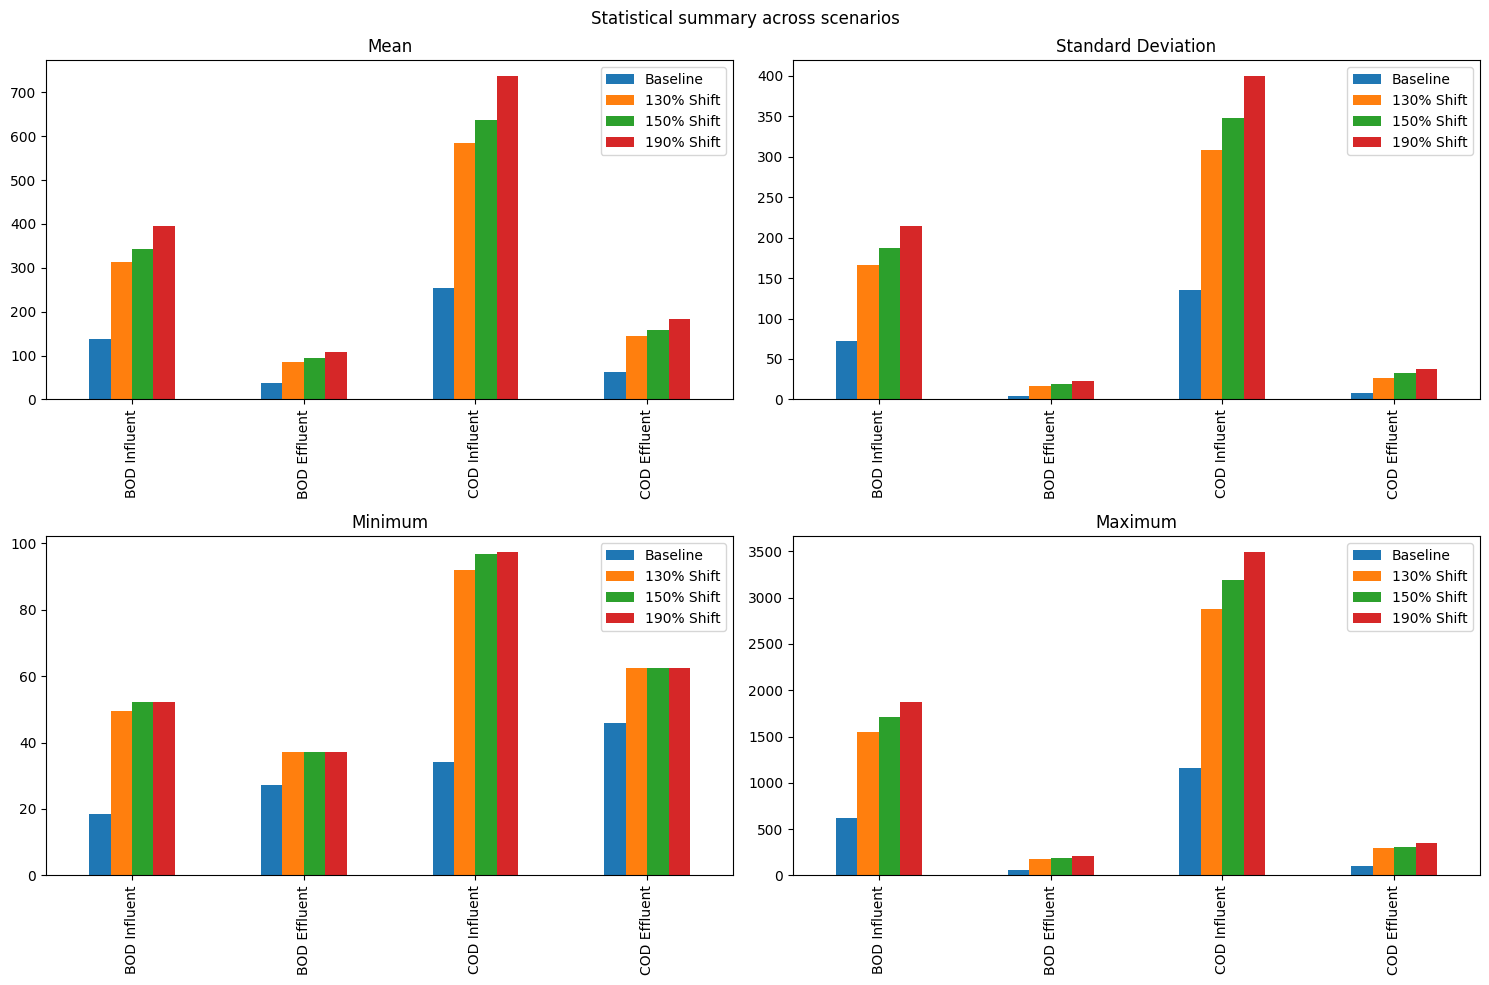

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example arrays for each scenario (replace these with your actual concatenated arrays)
# Assuming the lists are already concatenated as described before

# Create DataFrames and calculate statistics
stats_baseline = pd.DataFrame({
    'mean': [result_baseline["bod1"].mean(), result_baseline["bod31"].mean(), result_baseline["cod1"].mean(), result_baseline["cod31"].mean()],
    'std':  [result_baseline["bod1"].std(),  result_baseline["bod31"].std(),  result_baseline["cod1"].std(),  result_baseline["cod31"].std()],
    'min':  [result_baseline["bod1"].min(),  result_baseline["bod31"].min(),  result_baseline["cod1"].min(),  result_baseline["cod31"].min()],
    'max':  [result_baseline["bod1"].max(),  result_baseline["bod31"].max(),  result_baseline["cod1"].max(),  result_baseline["cod31"].max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

# Repeat for other scenarios
stats_shift130 = pd.DataFrame({
    'mean': [results_1_3["bod1"].mean(), results_1_3["bod31"].mean(), results_1_3["cod1"].mean(), results_1_3["cod31"].mean()],
    'std':  [results_1_3["bod1"].std(),  results_1_3["bod31"].std(),  results_1_3["cod1"].std(),  results_1_3["cod31"].std()],
    'min':  [results_1_3["bod1"].min(),  results_1_3["bod31"].min(),  results_1_3["cod1"].min(),  results_1_3["cod31"].min()],
    'max':  [results_1_3["bod1"].max(),  results_1_3["bod31"].max(),  results_1_3["cod1"].max(),  results_1_3["cod31"].max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

stats_shift150 = pd.DataFrame({
    'mean': [results_1_5["bod1"].mean(), results_1_5["bod31"].mean(), results_1_5["cod1"].mean(), results_1_5["cod31"].mean()],
    'std':  [results_1_5["bod1"].std(),  results_1_5["bod31"].std(),  results_1_5["cod1"].std(),  results_1_5["cod31"].std()],
    'min':  [results_1_5["bod1"].min(),  results_1_5["bod31"].min(),  results_1_5["cod1"].min(),  results_1_5["cod31"].min()],
    'max':  [results_1_5["bod1"].max(),  results_1_5["bod31"].max(),  results_1_5["cod1"].max(),  results_1_5["cod31"].max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

stats_shift190 = pd.DataFrame({
    'mean': [results_1_9["bod1"].mean(), results_1_9["bod31"].mean(), results_1_9["cod1"].mean(), results_1_9["cod31"].mean()],
    'std':  [results_1_9["bod1"].std(),  results_1_9["bod31"].std(),  results_1_9["cod1"].std(),  results_1_9["cod31"].std()],
    'min':  [results_1_9["bod1"].min(),  results_1_9["bod31"].min(),  results_1_9["cod1"].min(),  results_1_9["cod31"].min()],
    'max':  [results_1_9["bod1"].max(),  results_1_9["bod31"].max(),  results_1_9["cod1"].max(),  results_1_9["cod31"].max()]
}, index=['BOD Influent', 'BOD Effluent', 'COD Influent', 'COD Effluent'])

# Combine all the statistics into one DataFrame
combined_stats = pd.concat([stats_baseline, stats_shift130, stats_shift150, stats_shift190], axis=1)
combined_stats.columns = pd.MultiIndex.from_product([['Baseline', '130% Shift', '150% Shift', '190% Shift'], ['mean', 'std', 'min', 'max']])

# Plot the statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Statistical summary across scenarios')

combined_stats.xs('mean', level=1, axis=1).plot(kind='bar', ax=axes[0, 0], title='Mean')
combined_stats.xs('std', level=1, axis=1).plot(kind='bar', ax=axes[0, 1], title='Standard Deviation')
combined_stats.xs('min', level=1, axis=1).plot(kind='bar', ax=axes[1, 0], title='Minimum')
combined_stats.xs('max', level=1, axis=1).plot(kind='bar', ax=axes[1, 1], title='Maximum')

plt.tight_layout()
plt.show()


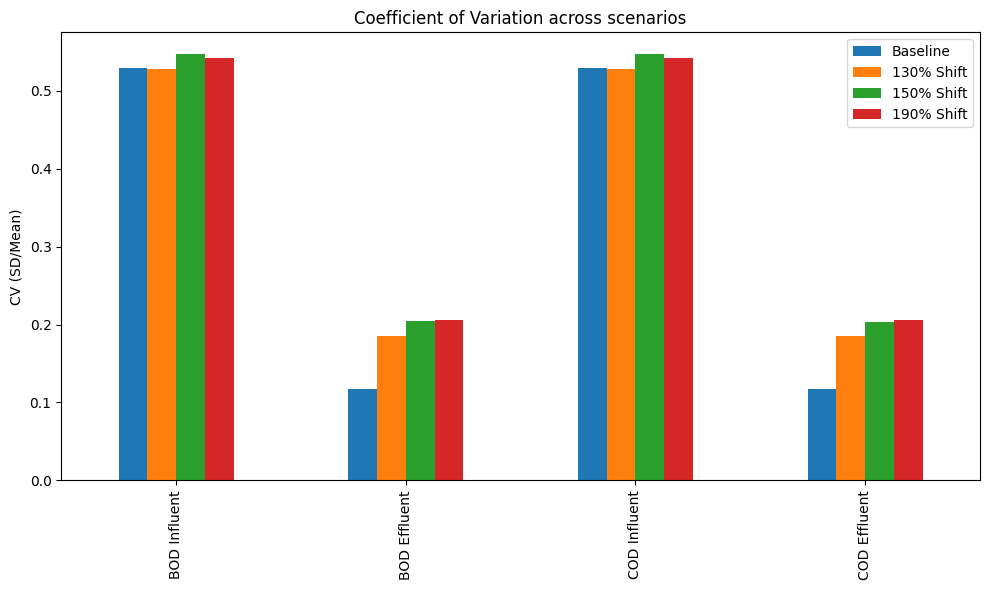

In [4]:
# Compute Coefficient of Variation (CV)
cv = combined_stats.xs('std', level=1, axis=1) / combined_stats.xs('mean', level=1, axis=1)

# Plot the Coefficient of Variation
fig, ax = plt.subplots(figsize=(10, 6))
cv.plot(kind='bar', ax=ax, title='Coefficient of Variation across scenarios')
ax.set_ylabel('CV (SD/Mean)')
plt.tight_layout()
plt.show()


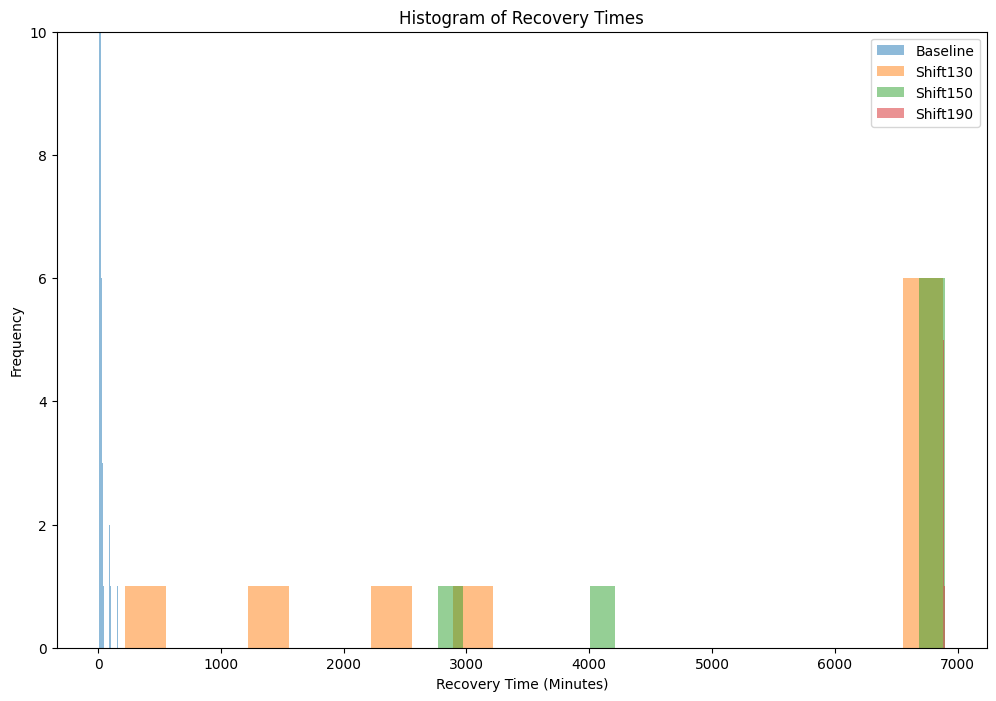

Mean recovery time for baseline: 12.579310344827586 minutes
Mean recovery time for shift130: 4804.3008 minutes
Mean recovery time for shift150: 6018.048000000001 minutes
Mean recovery time for shift190: 6883.035428571428 minutes


In [5]:
def compute_recovery_time(series, time_step=0.08):
    non_compliance_duration = 0
    recovery_times = []
    in_non_compliance = False

    for failure_type in series:
        if failure_type in ['Max Limit Failure', 'LUT exceedance']:
            if not in_non_compliance:
                in_non_compliance = True
            non_compliance_duration += 1
        else:
            if in_non_compliance:
                recovery_time = round(non_compliance_duration * time_step, 2)
                recovery_times.append(recovery_time)
                non_compliance_duration = 0
                in_non_compliance = False

    # Check for ongoing non-compliance at the end of the series
    if in_non_compliance:
        recovery_time = round(non_compliance_duration * time_step, 2)
        recovery_times.append(recovery_time)

    return recovery_times

# Compute recovery times for each series
recovery_times_baseline = compute_recovery_time(result_baseline["fail_type"])
recovery_times_shift130 = compute_recovery_time(results_1_3["fail_type"])
recovery_times_shift150 = compute_recovery_time(results_1_5["fail_type"])
recovery_times_shift190 = compute_recovery_time(results_1_9["fail_type"])


# Define the bins for the histogram
bins = 20
time_step = 0.08
hours_day = 24
minutes_hour = 60

# Convert recovery times to minutes
recovery_times_baseline_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_baseline]
recovery_times_shift130_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift130]
recovery_times_shift150_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift150]
recovery_times_shift190_minutes = [time * time_step * hours_day * minutes_hour for time in recovery_times_shift190]

# Plot histograms for each scenario
plt.figure(figsize=(12, 8))

plt.hist(recovery_times_baseline_minutes, bins=bins, alpha=0.5, label='Baseline')
plt.hist(recovery_times_shift130_minutes, bins=bins, alpha=0.5, label='Shift130')
plt.hist(recovery_times_shift150_minutes, bins=bins, alpha=0.5, label='Shift150')
plt.hist(recovery_times_shift190_minutes, bins=bins, alpha=0.5, label='Shift190')

plt.xlabel('Recovery Time (Minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Recovery Times')
plt.legend()
plt.ylim(0,10)
plt.show()
# Convert lists to NumPy arrays
recovery_times_baseline_minutes = np.array(recovery_times_baseline_minutes)
recovery_times_shift130_minutes = np.array(recovery_times_shift130_minutes)
recovery_times_shift150_minutes = np.array(recovery_times_shift150_minutes)
recovery_times_shift190_minutes = np.array(recovery_times_shift190_minutes)

# Calculate the mean for each dataset
mean_baseline = np.mean(recovery_times_baseline_minutes)
mean_shift130 = np.mean(recovery_times_shift130_minutes)
mean_shift150 = np.mean(recovery_times_shift150_minutes)
mean_shift190 = np.mean(recovery_times_shift190_minutes)

print(f"Mean recovery time for baseline: {mean_baseline} minutes")
print(f"Mean recovery time for shift130: {mean_shift130} minutes")
print(f"Mean recovery time for shift150: {mean_shift150} minutes")
print(f"Mean recovery time for shift190: {mean_shift190} minutes")



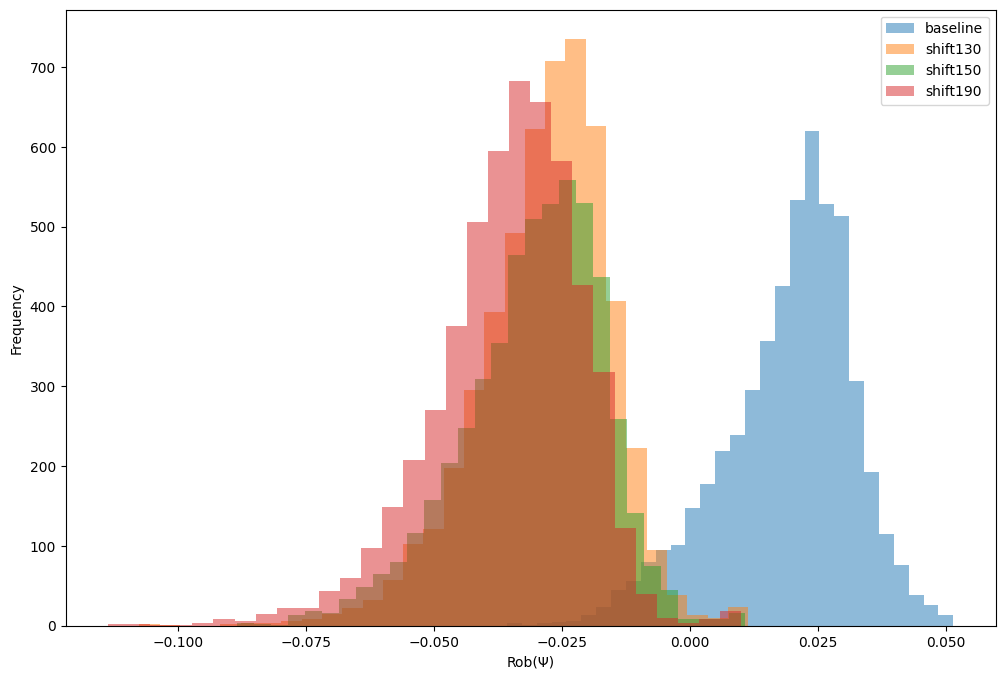

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract and flatten 'c_total' data for each scenario
c_total_data = {
    "baseline": result_baseline["metric"],
    "shift130": results_1_3["metric"],
    "shift150": results_1_5["metric"],
    "shift190": results_1_9["metric"]
}

# Plot the histogram
plt.figure(figsize=(12, 8))

# Plot histogram for each scenario
for scenario, values in c_total_data.items():
    plt.hist(values, bins=30, alpha=0.5, label=scenario)

# Add labels and title
plt.xlabel('Rob(Ψ)')
plt.ylabel('Frequency')
#plt.title('Histogram of c_total for Different Scenarios')
plt.legend(loc='upper right')

# Show the plot
plt.show()

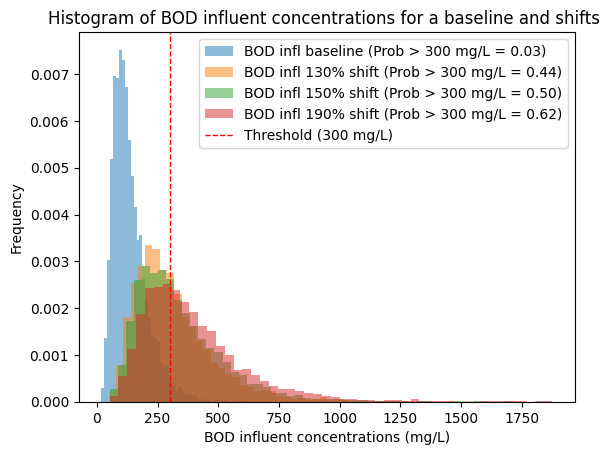

In [6]:

# Count the number of values above 300 mg/L in result_baseline["bod1"]
count_baseline_above_300 = sum(1 for value in result_baseline["bod1"] if value > 300)
# Calculate the probability
probability_baseline_above_300 = count_baseline_above_300 / len(result_baseline["bod1"])

# Count the number of values above 300 mg/L in results_1_3["bod1"]
count_shift130_above_300 = sum(1 for value in results_1_3["bod1"] if value > 300)
# Calculate the probability
probability_shift130_above_300 = count_shift130_above_300 / len(results_1_3["bod1"])

# Count the number of values above 300 mg/L in results_1_5["bod1"]
count_shift150_above_300 = sum(1 for value in results_1_5["bod1"] if value > 300)
# Calculate the probability
probability_shift150_above_300 = count_shift150_above_300 / len(results_1_5["bod1"])

# Count the number of values above 300 mg/L in results_1_9["bod1"]
count_shift190_above_300 = sum(1 for value in results_1_9["bod1"] if value > 300)
# Calculate the probability
probability_shift190_above_300 = count_shift190_above_300 / len(results_1_9["bod1"])

# Plot histogram for bodinfl_80
plt.hist(result_baseline["bod1"], bins=50, density=True, alpha=0.5, label=f'BOD infl baseline (Prob > 300 mg/L = {probability_baseline_above_300:.2f})')
plt.hist(results_1_3["bod1"], bins=50, density=True, alpha=0.5, label=f'BOD infl 130% shift (Prob > 300 mg/L = {probability_shift130_above_300:.2f})')
plt.hist(results_1_5["bod1"], bins=50, density=True, alpha=0.5, label=f'BOD infl 150% shift (Prob > 300 mg/L = {probability_shift150_above_300:.2f})')
plt.hist(results_1_9["bod1"], bins=50, density=True, alpha=0.5, label=f'BOD infl 190% shift (Prob > 300 mg/L = {probability_shift190_above_300:.2f})')
# Add a dotted line at 300 mg/L
plt.axvline(x=300, color='r', linestyle='--', linewidth=1, label='Threshold (300 mg/L)')

# Set labels and title
plt.xlabel('BOD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD influent concentrations for a baseline and shifts ')

plt.legend()

# Show the plot
plt.show()

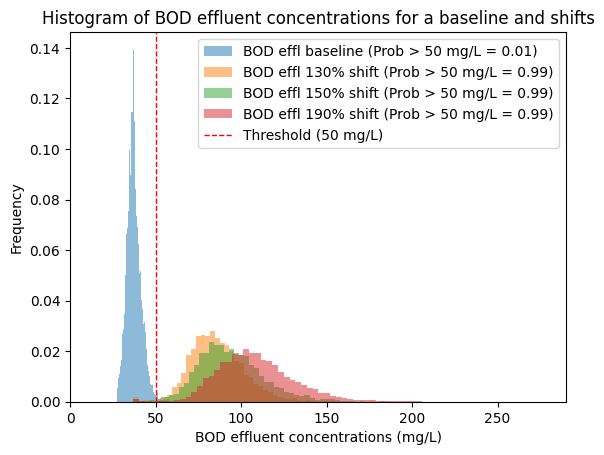

In [9]:
# Count the number of values above 50 mg/L in result_baseline["bod31"]
count_baseline_above_50 = sum(1 for value in result_baseline["bod31"] if value > 50)
# Calculate the probability
probability_baseline_above_50 = count_baseline_above_50 / len(result_baseline["bod31"])

# Count the number of values above 50 mg/L in results_1_3["bod31"]
count_shift130_above_50 = sum(1 for value in results_1_3["bod31"] if value > 50)
# Calculate the probability
probability_shift130_above_50 = count_shift130_above_50 / len(results_1_3["bod31"])

# Count the number of values above 50 mg/L in results_1_5["bod31"]
count_shift150_above_50 = sum(1 for value in results_1_5["bod31"] if value > 50)
# Calculate the probability
probability_shift150_above_50 = count_shift150_above_50 / len(results_1_5["bod31"])

# Count the number of values above 50 mg/L in results_1_9["bod31"] 
count_shift190_above_50 = sum(1 for value in results_1_9["bod31"] if value > 50)
# Calculate the probability
probability_shift190_above_50 = count_shift190_above_50 / len(results_1_9["bod31"])

# Plot histogram for bodeffl31
plt.hist(result_baseline["bod31"], bins=50, density=True, alpha=0.5, label=f'BOD effl baseline (Prob > 50 mg/L = {probability_baseline_above_50:.2f})')
plt.hist(results_1_3["bod31"], bins=50, density=True, alpha=0.5, label=f'BOD effl 130% shift (Prob > 50 mg/L = {probability_shift130_above_50:.2f})')
plt.hist(results_1_5["bod31"], bins=50, density=True, alpha=0.5, label=f'BOD effl 150% shift (Prob > 50 mg/L = {probability_shift150_above_50:.2f})')
plt.hist(results_1_9["bod31"], bins=50, density=True, alpha=0.5, label=f'BOD effl 190% shift (Prob > 50 mg/L = {probability_shift190_above_50:.2f})')

# Add a dotted line at 50 mg/L
plt.axvline(x=50, color='r', linestyle='--', linewidth=1, label='Threshold (50 mg/L)')

# Set labels and title
plt.xlabel('BOD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of BOD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 290)
plt.legend()

# Show the plot
plt.show()


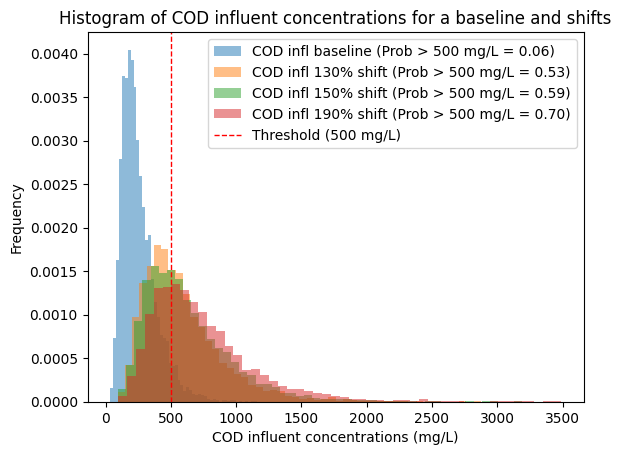

In [10]:
# Count the number of values above 500 mg/L in result_baseline["cod1"]
count_baseline_above_500 = sum(1 for value in result_baseline["cod1"] if value > 500)
# Calculate the probability
probability_baseline_above_500 = count_baseline_above_500 / len(result_baseline["cod1"])

# Count the number of values above 500 mg/L in results_1_3["cod1"]
count_shift130_above_500 = sum(1 for value in results_1_3["cod1"] if value > 500)
# Calculate the probability
probability_shift130_above_500 = count_shift130_above_500 / len(results_1_3["cod1"])

# Count the number of values above 500 mg/L in results_1_5["cod1"]
count_shift150_above_500 = sum(1 for value in results_1_5["cod1"] if value > 500)
# Calculate the probability
probability_shift150_above_500 = count_shift150_above_500 / len(results_1_5["cod1"])

# Count the number of values above 500 mg/L in results_1_5["cod1"]
count_shift190_above_500 = sum(1 for value in results_1_9["cod1"] if value > 500)
# Calculate the probability
probability_shift190_above_500 = count_shift190_above_500 / len(results_1_9["cod1"])

# Plot histogram for codinfl
plt.hist(result_baseline["cod1"], bins=50, density=True, alpha=0.5, label=f'COD infl baseline (Prob > 500 mg/L = {probability_baseline_above_500:.2f})')
plt.hist(results_1_3["cod1"], bins=50, density=True, alpha=0.5, label=f'COD infl 130% shift (Prob > 500 mg/L = {probability_shift130_above_500:.2f})')
plt.hist(results_1_5["cod1"], bins=50, density=True, alpha=0.5, label=f'COD infl 150% shift (Prob > 500 mg/L = {probability_shift150_above_500:.2f})')
plt.hist(results_1_9["cod1"], bins=50, density=True, alpha=0.5, label=f'COD infl 190% shift (Prob > 500 mg/L = {probability_shift190_above_500:.2f})')
# Add a dotted line at 500 mg/L
plt.axvline(x=500, color='r', linestyle='--', linewidth=1, label='Threshold (500 mg/L)')

# Set labels and title
plt.xlabel('COD influent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD influent concentrations for a baseline and shifts')

plt.legend()

# Show the plot
plt.show()


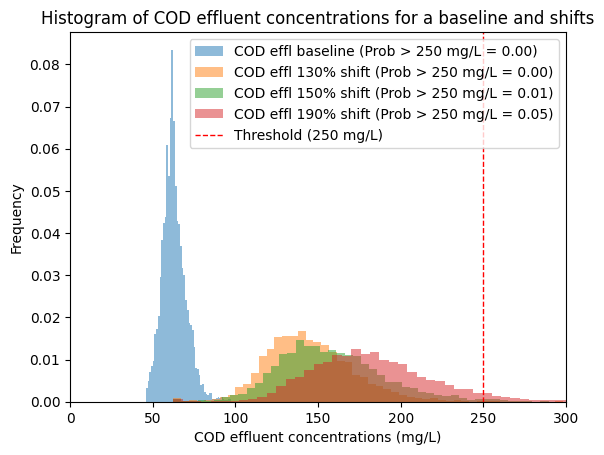

In [11]:
#baseline
count_baseline_above_250 = sum(1 for value in result_baseline["cod31"] if value > 250)
# Calculate the probability
probability_baseline_above_250 = count_baseline_above_250 / len(result_baseline["cod31"])

#130
count_shift130_above_250 = sum(1 for value in results_1_3["cod31"] if value > 250)
# Calculate the probability
probability_shift130_above_250 = count_shift130_above_250 / len(results_1_3["cod31"])

#150
count_shift150_above_250 = sum(1 for value in results_1_5["cod31"] if value > 250)
# Calculate the probability
probability_shift150_above_250 = count_shift150_above_250 / len(results_1_5["cod31"])

#190
count_shift190_above_250 = sum(1 for value in results_1_9["cod31"] if value > 250)
# Calculate the probability
probability_shift190_above_250 = count_shift190_above_250 / len(results_1_9["cod31"])

# Plot histogram for codeffl31
plt.hist(result_baseline["cod31"], bins=50, density=True, alpha=0.5, label=f'COD effl baseline (Prob > 250 mg/L = {probability_baseline_above_250:.2f})')
plt.hist(results_1_3["cod31"], bins=50, density=True, alpha=0.5, label=f'COD effl 130% shift (Prob > 250 mg/L = {probability_shift130_above_250:.2f})')
plt.hist(results_1_5["cod31"], bins=50, density=True, alpha=0.5, label=f'COD effl 150% shift (Prob > 250 mg/L = {probability_shift150_above_250:.2f})')
plt.hist(results_1_9["cod31"], bins=50, density=True, alpha=0.5, label=f'COD effl 190% shift (Prob > 250 mg/L = {probability_shift190_above_250:.2f})')

# Add a dotted line at 250 mg/L
plt.axvline(x=250, color='r', linestyle='--', linewidth=1, label='Threshold (250 mg/L)')

# Set labels and title
plt.xlabel('COD effluent concentrations (mg/L)')
plt.ylabel('Frequency')
plt.title('Histogram of COD effluent concentrations for a baseline and shifts')
# Set the x-axis limits
plt.xlim(0, 300)
plt.legend()

# Show the plot
plt.show()


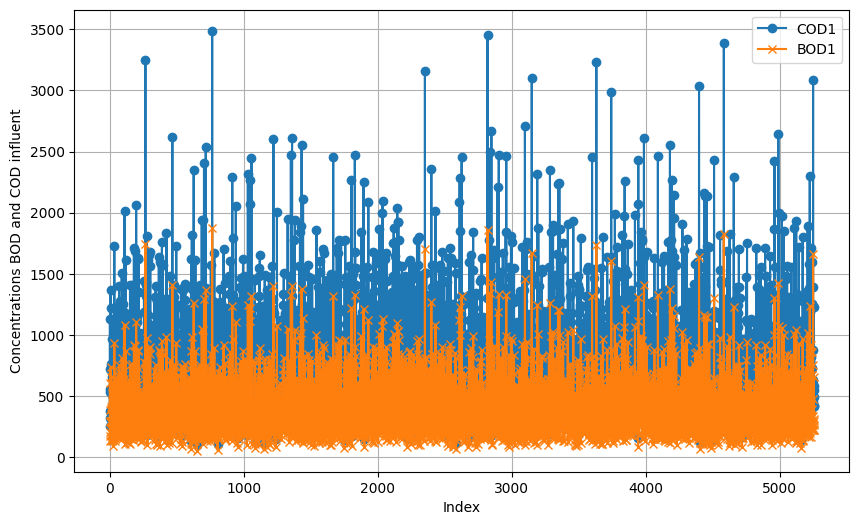

In [12]:
import matplotlib.pyplot as plt


# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(results_1_9.index, results_1_9['cod1'], label='COD1', marker='o')
plt.plot(results_1_9.index, results_1_9['bod1'], label='BOD1', marker='x')

# Adding titles and labels

plt.xlabel('Index')
plt.ylabel('Concentrations BOD and COD influent')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
